# Natural Language Inference Project

Loading the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/NLP_Project/

/content/drive/MyDrive/Colab Notebooks/NLP_Project


In [3]:
%ls

snli_1.0_dev.csv  snli_1.0_test.csv  snli_1.0_train.csv


Importing libraries

In [4]:
!pip install transformers

     |████████████████████████████████| 1.8MB 15.2MB/s 
     |████████████████████████████████| 2.9MB 56.2MB/s 
     |████████████████████████████████| 890kB 55.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=362a5323d70a04cf16a5e782a857a337f1e1a1c8e0bb564684b0b24babadc7f7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as svc
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
import torch
import transformers as trnsf
import warnings
warnings.filterwarnings('ignore')

Exploring the dataset:

In [6]:
cols = ['gold_label', 'sentence1', 'sentence2']
df = pd.read_csv('snli_1.0_train.csv', engine='python', usecols=cols)

In [7]:
df.info()

# There are missing values, so we need to drop those rows.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550152 entries, 0 to 550151
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   gold_label  550152 non-null  object
 1   sentence1   550152 non-null  object
 2   sentence2   550146 non-null  object
dtypes: object(3)
memory usage: 12.6+ MB


In [8]:
df = df[~df['sentence2'].isnull()]

In [9]:
df.info()

# Problem fixed! 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550146 entries, 0 to 550151
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   gold_label  550146 non-null  object
 1   sentence1   550146 non-null  object
 2   sentence2   550146 non-null  object
dtypes: object(3)
memory usage: 16.8+ MB


In [10]:
# Let's check if there are weird labels:
df.gold_label.value_counts()

# There are 785 rows with undifined category, for convenience, let's drop them too.

entailment       183414
contradiction    183185
neutral          182762
-                   785
Name: gold_label, dtype: int64

In [11]:
df = df[(df.gold_label != "-")]

In [12]:
# check:
df.gold_label.value_counts()

# Problem fixed! 

entailment       183414
contradiction    183185
neutral          182762
Name: gold_label, dtype: int64

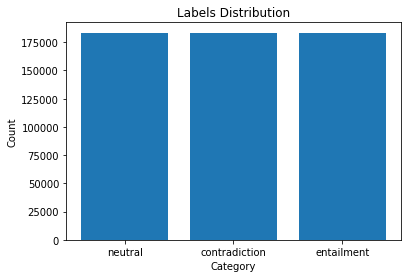

In [13]:
plt.bar(df.gold_label.unique(),df.gold_label.value_counts())
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Labels Distribution')
plt.show()

# The categories distribute equally.

In [14]:
print(df.shape)

(549361, 3)


In [15]:
df.head()

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


In [16]:
# Shuffling the dataset:
# We do that to increase the variance in the dataset.

df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [17]:
df.head()

,gold_label,sentence1,sentence2
0,neutral,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water.
1,entailment,A woman is smiling while the man next to her i...,Two people are next to each other.
2,neutral,"Across the river, you can see a large building.",The large building is full of apartments and t...
3,contradiction,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean.
4,contradiction,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...


In [18]:
# For performance reasons, we'll only use 4,000 sentences from the dataset

batch_1 = df[:4000]

In [19]:
batch_1.shape

(4000, 3)

In [20]:
batch_1['gold_label'].value_counts()

# We can see the distribution of the label is quite similar.

entailment       1347
contradiction    1345
neutral          1308
Name: gold_label, dtype: int64

Loading the Pre-trained BERT model

In [21]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (trnsf.DistilBertModel, trnsf.DistilBertTokenizer, 'distilbert-base-uncased')

# For Bert:
#model_class, tokenizer_class, pretrained_weights = (trnsf.BertModel, trnsf.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Preparing the Dataset

In [22]:
# Tokenizing the sentences:

s1_tokenized = batch_1['sentence1'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
s2_tokenized = batch_1['sentence2'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [23]:
# Padding:

# First let's find the max length of sentence1 and sentence2 columns:

# Sentence1
max_len_s1 = 0
for i in s1_tokenized.values:
    if len(i) > max_len_s1:
        max_len_s1 = len(i)

# Sentence2
max_len_s2 = 0
for i in s2_tokenized.values:
    if len(i) > max_len_s2:
        max_len_s2 = len(i)

# We will take the maximum value
max_len = max(max_len_s1, max_len_s2)
print("Max Length:", max_len)

Max Length: 74


In [24]:
# And do the padding:

padded_s1 = np.array([i + [0]*(max_len-len(i)) for i in s1_tokenized.values])
padded_s2 = np.array([i + [0]*(max_len-len(i)) for i in s2_tokenized.values])

In [25]:
# Check:
np.array(padded_s1).shape

# 3,000 is the number of rows I chose for the batch and 52 is the max legth
# Now each sentence padded to be in length of 52.

(4000, 74)

In [26]:
# Masking
# If we directly send padded to BERT, that would slightly confuse it. 
# We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. 
# That's what attention_mask is:

attention_mask = np.where(padded_s1 != 0, 1, 0)
attention_mask.shape

(4000, 74)

Modeling

In [27]:
input_ids_s1 = torch.tensor(padded_s1)
input_ids_s2 = torch.tensor(padded_s2)    
attention_mask = torch.tensor(attention_mask)

In [28]:
print(input_ids_s1)

tensor([[ 101, 1037, 2402,  ...,    0,    0,    0],
        [ 101, 1037, 2450,  ...,    0,    0,    0],
        [ 101, 2408, 1996,  ...,    0,    0,    0],
        ...,
        [ 101, 2048, 2273,  ...,    0,    0,    0],
        [ 101, 2019, 2019,  ...,    0,    0,    0],
        [ 101, 6927, 3917,  ...,    0,    0,    0]])


In [29]:
with torch.no_grad():
    last_hidden_state_s1 = model(input_ids_s1, attention_mask=attention_mask)

In [30]:
with torch.no_grad():
    last_hidden_state_s2 = model(input_ids_s2, attention_mask=attention_mask)

In [31]:
features_s1 = last_hidden_state_s1[0][:,0,:].numpy()
features_s2 = last_hidden_state_s2[0][:,0,:].numpy()

In [32]:
diff_features = features_s1 - features_s2 # Simple substraction

In [33]:
cosine_diff_features = [1 - spatial.distance.cosine(features_s1[i], features_s2[i]) for i in range(len(features_s2))]
cosine_diff_features = np.asarray(cosine_diff_features).reshape(-1, 1)

In [34]:
print('features_s1 shape:', features_s1.shape)
print('diff_features shape:', diff_features.shape)
print('cosine_diff_features shape:', cosine_diff_features.shape)

features_s1 shape: (4000, 768)
diff_features shape: (4000, 768)
cosine_diff_features shape: (4000, 1)


In [35]:
features = np.concatenate((features_s1, features_s2), axis=1)

In [36]:
features.shape

(4000, 1536)

In [37]:
labels = batch_1.gold_label

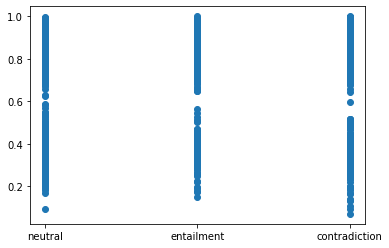

In [38]:
plt.scatter(labels, cosine_diff_features);

Creating Logistic regression:

First try using concatenate of the fetures and Logisitic Regression Classifier:

In [39]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=1)

In [40]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# Evaluating model's results:
lr_clf.score(test_features, test_labels)

0.512

In [42]:
# Using cross validation:
np.mean(cross_val_score(lr_clf, test_features, test_labels, cv=7))

0.49605324253211575

Second try using the difference of the features and Logisitic Regression Classifier:

In [43]:
train_features, test_features, train_labels, test_labels = train_test_split(diff_features, labels, random_state=1)

In [44]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# Evaluating model's results:
lr_clf.score(test_features, test_labels)

0.491

In [46]:
# Using cross validation:
np.mean(cross_val_score(lr_clf, test_features, test_labels, cv=7))

0.46502792981666224

Third try using concatenate of the fetures and SVC Classifier:

In [47]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=1)

In [48]:
svc_clf = svc(kernel='linear', C=1).fit(train_features, train_labels)

In [49]:
# Evaluating model's results:
svc_clf.score(test_features, test_labels)

0.487

In [50]:
# Using cross validation:
np.mean(cross_val_score(svc_clf, test_features, test_labels, cv=7))

0.4680671441234822

Forth try using the difference of the features and SVC Classifier:

In [51]:
train_features, test_features, train_labels, test_labels = train_test_split(diff_features, labels, random_state=1)

In [52]:
svc_clf = svc(kernel='linear', C=1).fit(train_features, train_labels)

In [53]:
# Evaluating model's results:
svc_clf.score(test_features, test_labels)

0.467

In [54]:
# Using cross validation:
np.mean(cross_val_score(svc_clf, test_features, test_labels, cv=7))

0.415007527683584

Fifth try using the difference of the features and majority voting classifier (ensembles) :

In [55]:
ecf = VotingClassifier(estimators=[('lr', lr_clf), ('svc', svc_clf)], voting='hard').fit(train_features, train_labels)

In [56]:
ecf.score(test_features, test_labels)

0.47

In [57]:
# Using cross validation:
np.mean(cross_val_score(ecf, test_features, test_labels, cv=7))

0.4370207257531202